## Supervised Learning Methods & Models 

In this section, I will be using various supervised learning models to predict what the counts of Lymes disease will be in each region in the year 2050 under the RCP 8.5 Climate Scenario. I will compare the accuracy of the trained models to determine the optimal model, and perform my final prediction with that model. 

### Initialize Carbon Tracker 

The code below was taken from Climate Change AI's tutorial on Tracking Emissions from ML Models.

In [41]:
from codecarbon import EmissionsTracker

# Instantiate the tracker object
tracker = EmissionsTracker(
    output_dir="../data/clean_data/",  # define the directory to which we'll write our emissions results
    output_file="carbon_emissions.csv",  # define the name of the file containing our emissions results
    # log_level='error' # comment out this line to see regular output
)
tracker.start()

[codecarbon INFO @ 14:23:09] [setup] RAM Tracking...
[codecarbon INFO @ 14:23:09] [setup] GPU Tracking...
[codecarbon INFO @ 14:23:09] No GPU found.
[codecarbon INFO @ 14:23:09] [setup] CPU Tracking...
[codecarbon WARNING @ 14:23:19] No CPU tracking mode found. Falling back on CPU constant mode. 
 Mac OS detected: Please install Intel Power Gadget or enable PowerMetrics sudo to measure CPU

[codecarbon INFO @ 14:23:22] CPU Model on constant consumption mode: Intel(R) Core(TM) i5-1030NG7 CPU @ 1.10GHz
[codecarbon INFO @ 14:23:22] >>> Tracker's metadata:
[codecarbon INFO @ 14:23:22]   Platform system: macOS-14.3.1-x86_64-i386-64bit
[codecarbon INFO @ 14:23:22]   Python version: 3.12.2
[codecarbon INFO @ 14:23:22]   CodeCarbon version: 2.8.1
[codecarbon INFO @ 14:23:22]   Available RAM : 8.000 GB
[codecarbon INFO @ 14:23:22]   CPU count: 8
[codecarbon INFO @ 14:23:22]   CPU model: Intel(R) Core(TM) i5-1030NG7 CPU @ 1.10GHz
[codecarbon INFO @ 14:23:22]   GPU count: None
[codecarbon INFO @ 

In [ ]:
import pandas as pd
df = pd.read_csv('../data/clean_data/data.csv')
df.columns

Index(['Year', 'Precipitation_avg', 'region', 'Min_temp_avg', 'Avg_temp',
       'State', 'Lyme_cases', 'Total_Land_Area', 'Tree_Cover_Loss',
       'species_richness', 'state_park_land_coverage', 'state_park_rank'],
      dtype='object')

[codecarbon INFO @ 14:25:09] Energy consumed for RAM : 0.000086 kWh. RAM Power : 3.0 W
[codecarbon INFO @ 14:25:09] Energy consumed for all CPUs : 0.000143 kWh. Total CPU Power : 5.0 W
[codecarbon INFO @ 14:25:09] 0.000229 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:25:24] Energy consumed for RAM : 0.000098 kWh. RAM Power : 3.0 W
[codecarbon INFO @ 14:25:24] Energy consumed for all CPUs : 0.000164 kWh. Total CPU Power : 5.0 W
[codecarbon INFO @ 14:25:24] 0.000262 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:25:39] Energy consumed for RAM : 0.000111 kWh. RAM Power : 3.0 W
[codecarbon INFO @ 14:25:39] Energy consumed for all CPUs : 0.000185 kWh. Total CPU Power : 5.0 W
[codecarbon INFO @ 14:25:39] 0.000296 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:25:39] 0.000484 g.CO2eq/s mean an estimation of 15.269735288828997 kg.CO2eq/year


## Perform supervised learning

In [ ]:
# load packages
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.kernel_ridge import KernelRidge
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.tree import plot_tree

### Clean data

In [ ]:

def prepare_training_data(df):
    # aggregate by region with additional variables
    df_agg = df.groupby(['Year', 'region']).agg({
        'Precipitation_avg': 'first', # can specify to first because all of the Precipitation_avg is the same for each level of the region, same for the other climate variables
        'Min_temp_avg': 'first', 
        'Avg_temp': 'first',
        'Total_Land_Area': 'sum',
        'state_park_land_coverage': 'mean',
        'state_park_rank': 'mean',
        'Lyme_cases': 'sum'
    }).reset_index()
    
    X = df_agg[['Min_temp_avg', 'Avg_temp', 'Precipitation_avg', 
                'Total_Land_Area', 'state_park_land_coverage', 'state_park_rank']]
    y = df_agg['Lyme_cases']
    
    imputer = SimpleImputer(strategy='mean')
    X = imputer.fit_transform(X)
    return X, y, imputer

def prepare_future_data(future_df, imputer):
    # Pivot wider temperature and precipitation data
    future_wide = future_df.pivot(index='region', 
                                columns='Indicator', 
                                values='value')
    
    # Add the static variables (don't change over time)
    future_wide['Total_Land_Area'] = future_df.groupby('region')['Total_Land_Area'].first()
    future_wide['state_park_land_coverage'] = future_df.groupby('region')['state_park_land_coverage'].first()
    future_wide['state_park_rank'] = future_df.groupby('region')['state_park_rank'].first()
    
    X_future = future_wide[['Min_temp', 'Avg_temp', 'Precipitation_avg', 
                           'Total_Land_Area', 'state_park_land_coverage', 'state_park_rank']].values
    return X_future, future_wide.index


[codecarbon INFO @ 14:27:54] Energy consumed for RAM : 0.000223 kWh. RAM Power : 3.0 W
[codecarbon INFO @ 14:27:54] Energy consumed for all CPUs : 0.000372 kWh. Total CPU Power : 5.0 W
[codecarbon INFO @ 14:27:54] 0.000595 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:28:09] Energy consumed for RAM : 0.000236 kWh. RAM Power : 3.0 W
[codecarbon INFO @ 14:28:09] Energy consumed for all CPUs : 0.000393 kWh. Total CPU Power : 5.0 W
[codecarbon INFO @ 14:28:09] 0.000629 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:28:24] Energy consumed for RAM : 0.000248 kWh. RAM Power : 3.0 W
[codecarbon INFO @ 14:28:24] Energy consumed for all CPUs : 0.000414 kWh. Total CPU Power : 5.0 W
[codecarbon INFO @ 14:28:24] 0.000662 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:28:39] Energy consumed for RAM : 0.000260 kWh. RAM Power : 3.0 W
[codecarbon INFO @ 14:28:39] Energy consumed for all CPUs : 0.000435 kWh. Total CPU Power : 5.0 W
[codecarbon

### Train models

Nine supervised learning models (Linear Regression, Ridge Regression, Lasso Regression, Elastic Net, Random Forests, Gradient Boosting, AdaBoost, KNN, SVR (RBF) and Kernel Ridge) will be trained on the existing data, evaluated for their accuracy, and compared. These models were chosen in order to have a diverse range of regression and ensemble methods. 

/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.166e+08, tolerance: 4.664e+05
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.529e+08, tolerance: 4.097e+05
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.320e+08, toler


Model Performance Metrics:

Linear Regression:
RMSE: 7423.5828
R2: 0.7478
CV_mean: 0.6778
CV_std: 0.3981

Ridge:
RMSE: 7406.3952
R2: 0.7490
CV_mean: 0.8207
CV_std: 0.1228

Lasso:
RMSE: 7424.4735
R2: 0.7477
CV_mean: 0.7023
CV_std: 0.3505

Random Forest:
RMSE: 8704.5666
R2: 0.6533
CV_mean: 0.8702
CV_std: 0.0644

Gradient Boosting:
RMSE: 10893.7150
R2: 0.4569
CV_mean: 0.8229
CV_std: 0.0561

AdaBoost:
RMSE: 11394.8599
R2: 0.4058
CV_mean: 0.8310
CV_std: 0.0932

KNN:
RMSE: 9747.6350
R2: 0.5652
CV_mean: 0.8890
CV_std: 0.0714

SVR (RBF):
RMSE: 19782.2224
R2: -0.7908
CV_mean: -0.4084
CV_std: 0.3519

Kernel Ridge:
RMSE: 9060.9966
R2: 0.6243
CV_mean: 0.8958
CV_std: 0.0366


KeyError: 'Indicator'

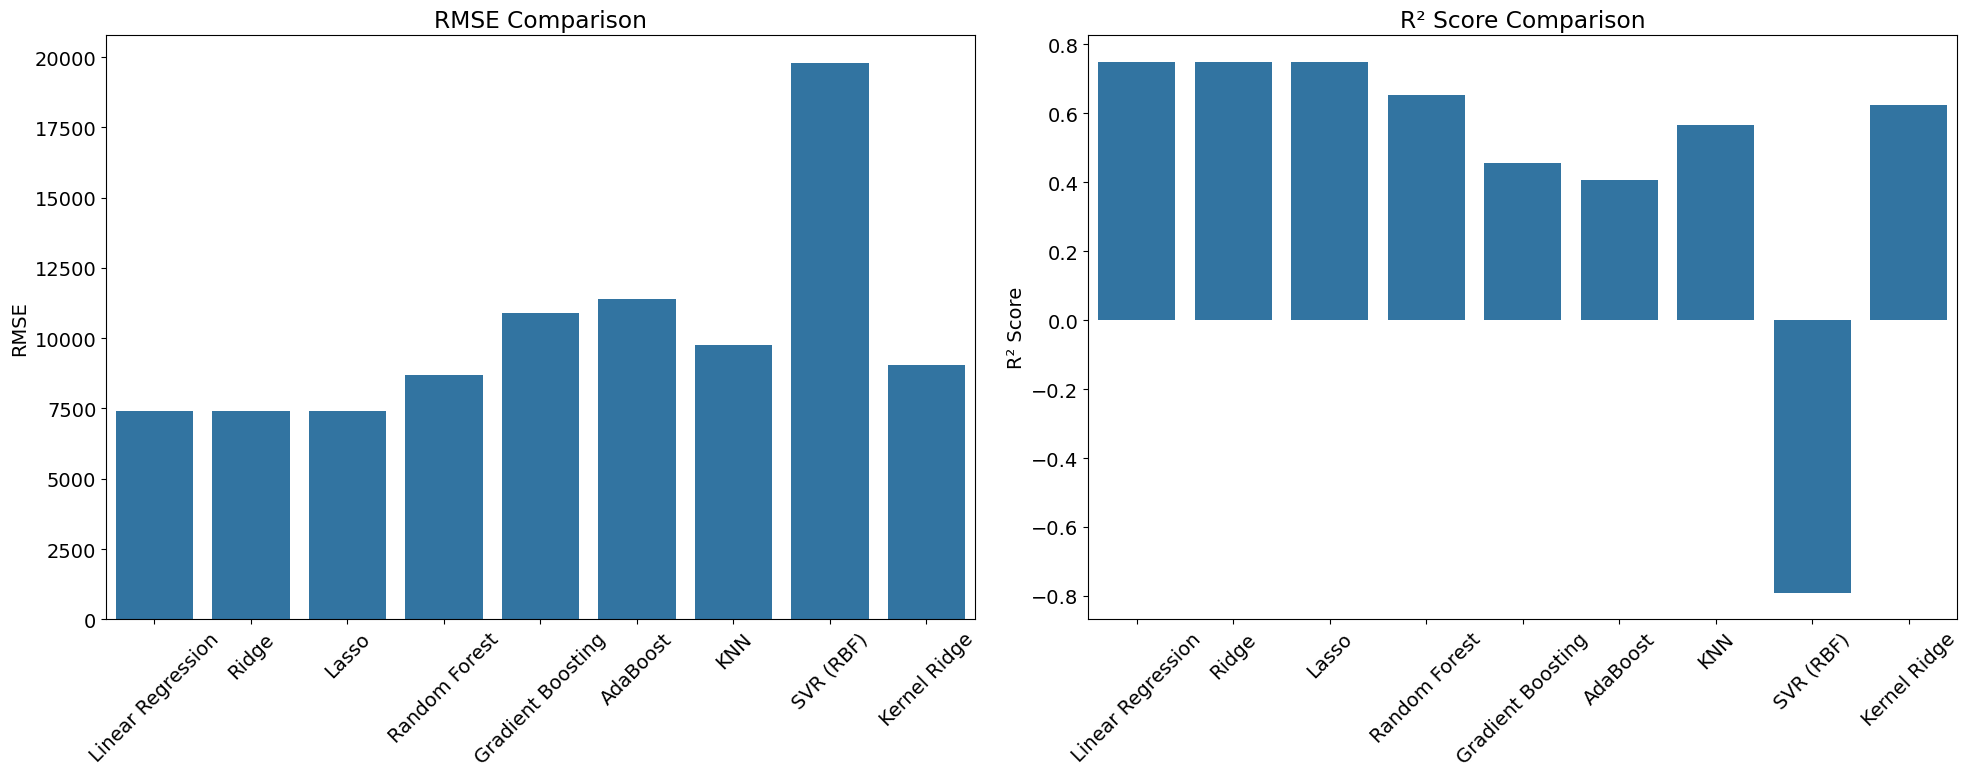

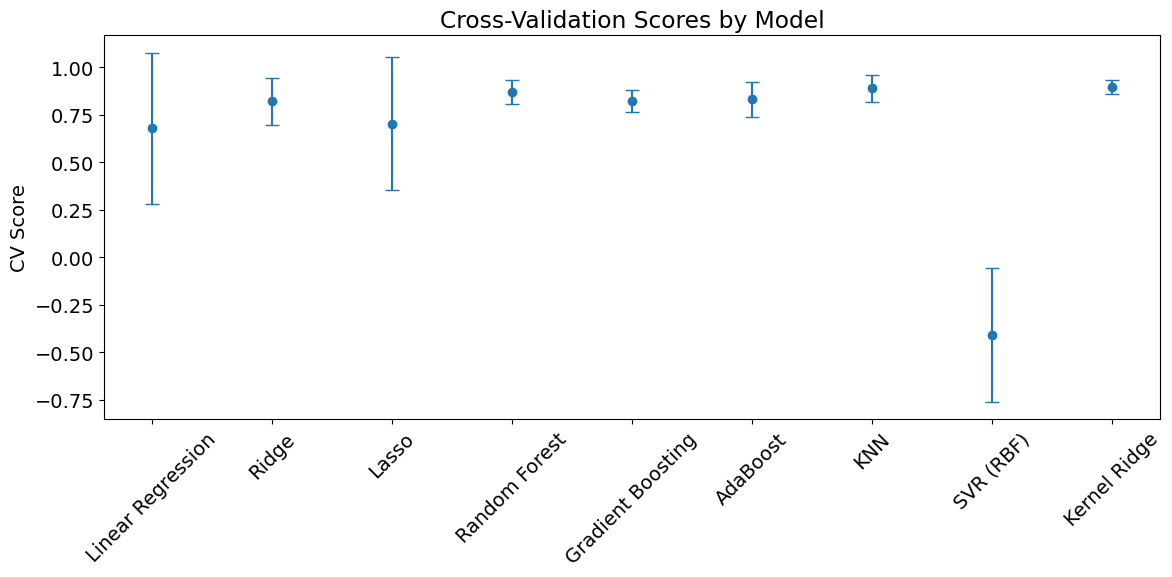

[codecarbon INFO @ 14:40:25] Energy consumed for RAM : 0.000848 kWh. RAM Power : 3.0 W
[codecarbon INFO @ 14:40:25] Energy consumed for all CPUs : 0.001414 kWh. Total CPU Power : 5.0 W
[codecarbon INFO @ 14:40:25] 0.002261 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:40:40] Energy consumed for RAM : 0.000860 kWh. RAM Power : 3.0 W
[codecarbon INFO @ 14:40:40] Energy consumed for all CPUs : 0.001434 kWh. Total CPU Power : 5.0 W
[codecarbon INFO @ 14:40:40] 0.002294 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:40:55] Energy consumed for RAM : 0.000872 kWh. RAM Power : 3.0 W
[codecarbon INFO @ 14:40:55] Energy consumed for all CPUs : 0.001455 kWh. Total CPU Power : 5.0 W
[codecarbon INFO @ 14:40:55] 0.002328 kWh of electricity used since the beginning.


In [ ]:

def train_and_evaluate_expanded_models(X, y):
   # Split the data
   X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
   
   # Scale the features
   scaler = StandardScaler()
   X_train_scaled = scaler.fit_transform(X_train)
   X_test_scaled = scaler.transform(X_test)
   
   # Initialize expanded set of models
   models = {
       'Linear Regression': LinearRegression(),
       'Ridge': Ridge(alpha=0.1),
       'Lasso': Lasso(alpha=0.1),
       'Random Forest': RandomForestRegressor(n_estimators=200, min_samples_leaf=2),
       'Gradient Boosting': GradientBoostingRegressor(n_estimators=200, learning_rate=0.1),
       'AdaBoost': AdaBoostRegressor(n_estimators=200),
       'KNN': KNeighborsRegressor(n_neighbors=3),
       'SVR (RBF)': SVR(kernel='rbf', C=10),
       'Kernel Ridge': KernelRidge(kernel='rbf', alpha=0.1)
   }
   
   # Train and evaluate models
   results = {}
   trained_models = {}
   
   for name, model in models.items():
       try:
           # Train model
           model.fit(X_train_scaled, y_train)
           
           # Make predictions
           y_pred = model.predict(X_test_scaled)
           
           # Calculate metrics
           mse = mean_squared_error(y_test, y_pred)
           rmse = np.sqrt(mse)
           r2 = r2_score(y_test, y_pred)
           
           # Perform cross-validation
           cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5)
           
           results[name] = {
               'RMSE': rmse,
               'R2': r2,
               'CV_mean': cv_scores.mean(),
               'CV_std': cv_scores.std()
           }
           trained_models[name] = model
           
       except Exception as e:
           print(f"Error training {name}: {str(e)}")
   
   return results, trained_models, scaler

def plot_expanded_model_comparison(results):
   # Create figure with two subplots
   fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
   
   # Prepare data for plotting
   models = list(results.keys())
   rmse_scores = [results[model]['RMSE'] for model in models]
   r2_scores = [results[model]['R2'] for model in models]
   
   # Plot RMSE comparison
   sns.barplot(x=models, y=rmse_scores, ax=ax1)
   ax1.set_title('RMSE Comparison')
   ax1.set_ylabel('RMSE')
   ax1.tick_params(axis='x', rotation=45)
   
   # Plot R² comparison
   sns.barplot(x=models, y=r2_scores, ax=ax2)
   ax2.set_title('R² Score Comparison')
   ax2.set_ylabel('R² Score')
   ax2.tick_params(axis='x', rotation=45)
   
   plt.tight_layout()
   return fig

def plot_cross_validation_results(results):
   fig, ax = plt.subplots(figsize=(12, 6))
   
   models = list(results.keys())
   cv_means = [results[model]['CV_mean'] for model in models]
   cv_stds = [results[model]['CV_std'] for model in models]
   
   # Plot CV scores with error bars
   ax.errorbar(models, cv_means, yerr=cv_stds, fmt='o', capsize=5)
   ax.set_title('Cross-Validation Scores by Model')
   ax.set_ylabel('CV Score')
   plt.xticks(rotation=45)
   plt.tight_layout()
   
   return fig

# Main execution
if __name__ == "__main__":
   # Load and prepare data
   hist_df = pd.read_csv('../data/clean_data/data.csv')
   future_df = pd.read_csv('../data/clean_data/2050inputs.csv')
   
   X, y, imputer = prepare_training_data(hist_df)
   
   # Train and evaluate expanded set of models
   results, trained_models, scaler = train_and_evaluate_expanded_models(X, y)
   
   # Print detailed results
   print("\nModel Performance Metrics:")
   for model_name, metrics in results.items():
       print(f"\n{model_name}:")
       for metric_name, value in metrics.items():
           print(f"{metric_name}: {value:.4f}")
   
   # Plot comparisons
   comparison_fig = plot_expanded_model_comparison(results)
   cv_fig = plot_cross_validation_results(results)
   
   # Prepare and predict with 2050 data
   future_X, future_regions = prepare_future_data(future_df, imputer)
   future_X_scaled = scaler.transform(future_X)

### Make predictions using 2050 inputs

In [50]:

# Make predictions for 2050
print("\nPredicted Lyme Disease Cases for 2050 by Region:")
for model_name, model in trained_models.items():
    predictions = model.predict(future_X_scaled)
    print(f"\n{model_name} predictions:")
    for region, pred in zip(future_regions, predictions):
        print(f"{region}: {max(0, int(pred))} cases")


Predicted Lyme Disease Cases for 2050 by Region:

Linear Regression predictions:
central: 0 cases
eastern: 14330 cases
southern: 0 cases
western: 0 cases

Ridge predictions:
central: 0 cases
eastern: 7538 cases
southern: 0 cases
western: 0 cases

Lasso predictions:
central: 0 cases
eastern: 14470 cases
southern: 0 cases
western: 0 cases

Random Forest predictions:
central: 5304 cases
eastern: 13705 cases
southern: 2248 cases
western: 1214 cases

Gradient Boosting predictions:
central: 5588 cases
eastern: 12118 cases
southern: 2095 cases
western: 1852 cases

AdaBoost predictions:
central: 4648 cases
eastern: 22215 cases
southern: 3292 cases
western: 2966 cases

KNN predictions:
central: 195 cases
eastern: 20998 cases
southern: 4173 cases
western: 195 cases

SVR (RBF) predictions:
central: 2387 cases
eastern: 2387 cases
southern: 2387 cases
western: 2387 cases

Kernel Ridge predictions:
central: 0 cases
eastern: 87 cases
southern: 0 cases
western: 0 cases


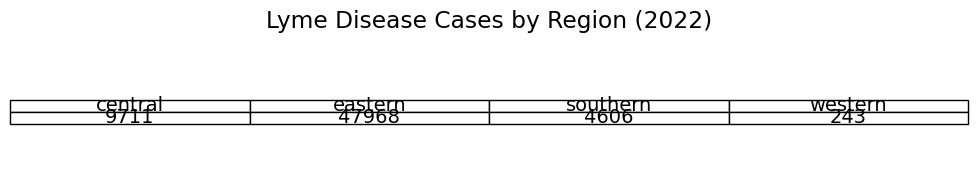

In [51]:
# Get 2022 data counts by region
hist_2022 = hist_df[hist_df['Year'] == 2022].groupby('region')['Lyme_cases'].sum()

# Create figure and axis
plt.figure(figsize=(10, 2))

# Create table data
table_data = [hist_2022.values]
table_cols = hist_2022.index

# Create table
plt.table(cellText=table_data,
          colLabels=table_cols,
          cellLoc='center',
          loc='center',
          edges='closed')

# Remove axes
plt.axis('off')

# Add title
plt.title('Lyme Disease Cases by Region (2022)', pad=20)

plt.tight_layout()
plt.show()



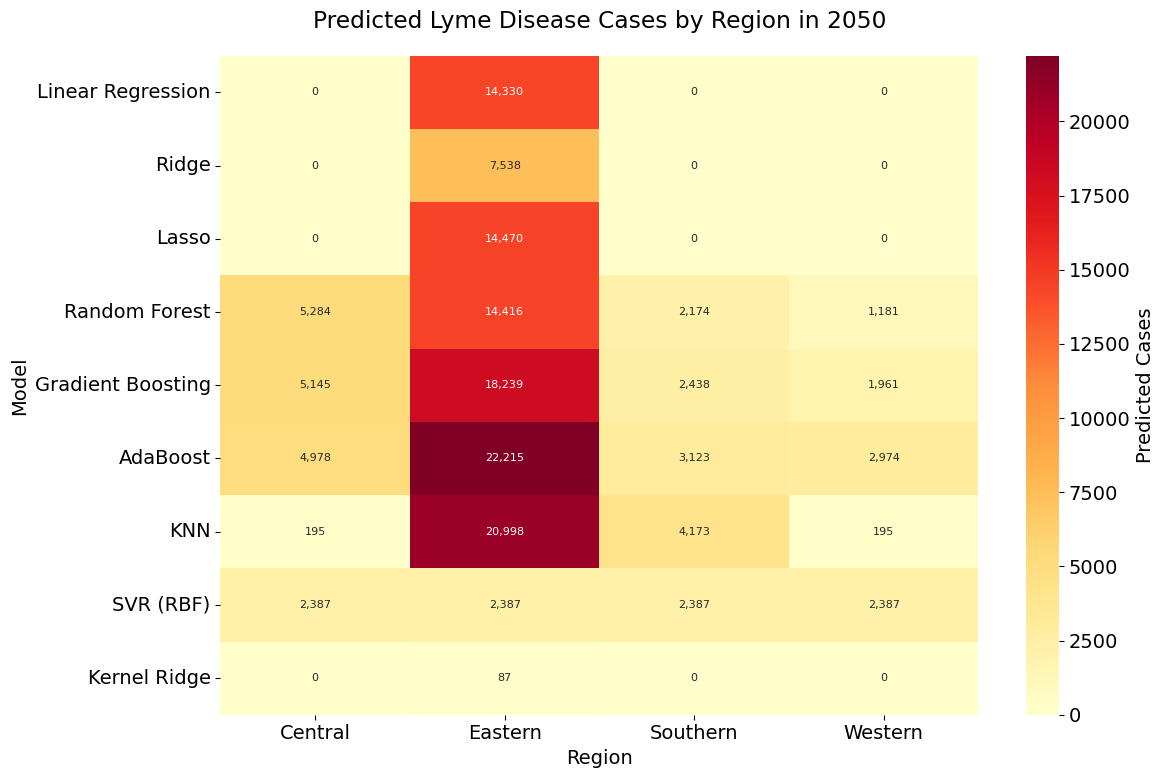

In [52]:
# Heatmap 
def create_predictions_heatmap():
    # Create predictions dictionary
    predictions = {
        'Linear Regression': [0, 14330, 0, 0],
        'Ridge': [0, 7538, 0, 0],
        'Lasso': [0, 14470, 0, 0],
        'Random Forest': [5284, 14416, 2174, 1181],
        'Gradient Boosting': [5145, 18239, 2438, 1961],
        'AdaBoost': [4978, 22215, 3123, 2974],
        'KNN': [195, 20998, 4173, 195],
        'SVR (RBF)': [2387, 2387, 2387, 2387],
        'Kernel Ridge': [0, 87, 0, 0]
    }
    
    # Convert to DataFrame
    df = pd.DataFrame(predictions, 
                     index=['Central', 'Eastern', 'Southern', 'Western']).T
    
    # Create figure
    plt.figure(figsize=(12, 8))
    
    # Create heatmap
    sns.heatmap(df, annot=True, fmt=',d', cmap='YlOrRd',
                cbar_kws={'label': 'Predicted Cases'},
                annot_kws={'size': 8})
    
    plt.title('Predicted Lyme Disease Cases by Region in 2050', pad=20)
    plt.ylabel('Model')
    plt.xlabel('Region')
    
    # Rotate x-axis labels for better readability
    plt.xticks(rotation=0)
    plt.yticks(rotation=0)
    
    plt.tight_layout()
    return plt.gcf()

# Create the visualization
fig = create_predictions_heatmap()
plt.show()


Detailed Regional Comparison:
          2022 Actual  2050 Random Forest  2050 Gradient Boosting  2050 AdaBoost  2050 KNN  Random Forest % Change  Gradient Boosting % Change  AdaBoost % Change  KNN % Change
region                                                                                                                                                                         
western           343              1214.0                  1852.7         2966.0     195.7                   253.9                       440.1              764.7         -43.0
southern         2808              2248.8                  2095.6         3292.0    4173.3                   -19.9                       -25.4               17.2          48.6
central          5583              5304.7                  5588.2         4648.8     195.7                    -5.0                         0.1              -16.7         -96.5
eastern         26170             13705.4                 12118.1        22215.0   20998.

[codecarbon INFO @ 14:41:10] Energy consumed for RAM : 0.000885 kWh. RAM Power : 3.0 W
[codecarbon INFO @ 14:41:10] Energy consumed for all CPUs : 0.001476 kWh. Total CPU Power : 5.0 W
[codecarbon INFO @ 14:41:10] 0.002361 kWh of electricity used since the beginning.


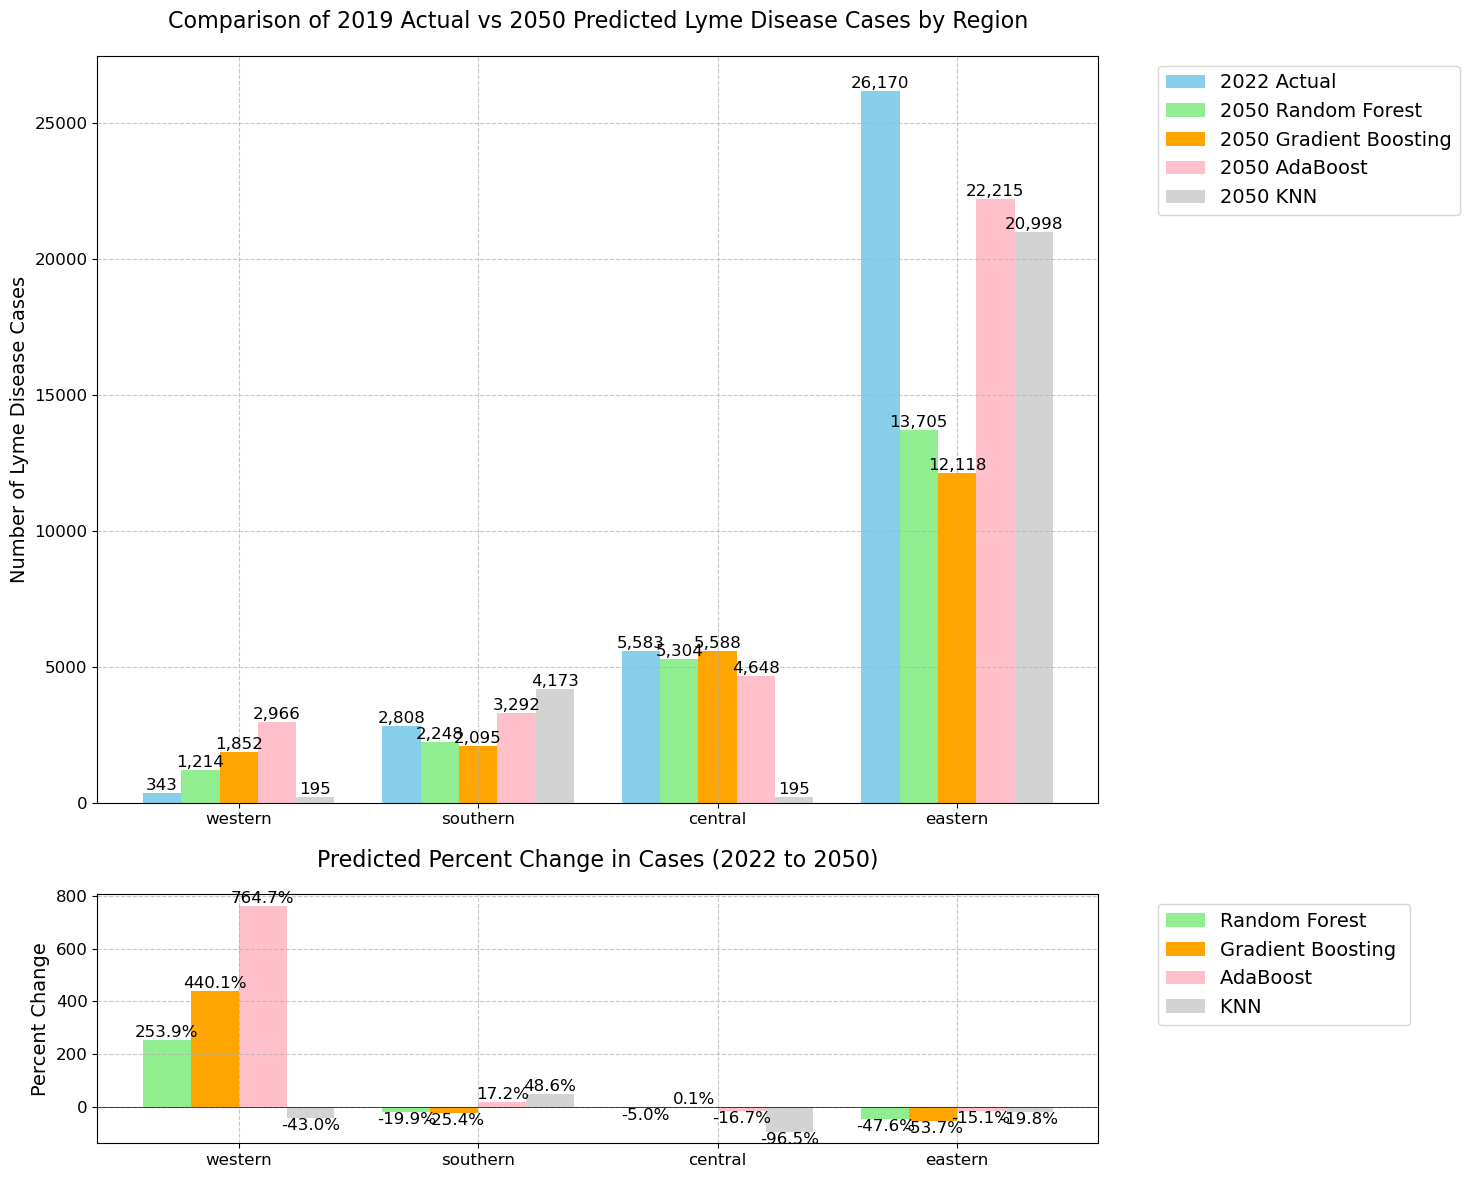

In [53]:
def plot_multiple_models_comparison(hist_df, future_regions, predictions_dict, year_to_compare=2019):
    """
    Create a visualization comparing multiple models' 2050 predictions with 2022 historical data.
    
    Parameters:
    -----------
    hist_df : pandas DataFrame
        Historical data containing Year, region, and Lyme_cases
    future_regions : array-like
        List of regions for which predictions were made
    predictions_dict : dict
        Dictionary containing predictions for each model
    year_to_compare : int
        Year to compare with predictions (default 2022)
    """
    # Get historical data for the comparison year
    hist_data = hist_df[hist_df['Year'] == year_to_compare].groupby('region')['Lyme_cases'].sum()
    
    # Create DataFrame with all values
    comparison_df = pd.DataFrame({
        '2022 Actual': [hist_data.get(region, 0) for region in future_regions],
    }, index=future_regions)
    
    # Add predictions for each model
    for model_name, predictions in predictions_dict.items():
        comparison_df[f'2050 {model_name}'] = predictions
    
    # Calculate percent changes for each model
    base_values = comparison_df['2022 Actual']
    for model_name in predictions_dict.keys():
        pred_col = f'2050 {model_name}'
        comparison_df[f'{model_name} % Change'] = (
            (comparison_df[pred_col] - base_values) / base_values * 100
        )
    
    # Sort by 2022 values for better visualization
    comparison_df = comparison_df.sort_values('2022 Actual', ascending=True)
    
    # Set font sizes
    plt.rcParams.update({'font.size': 14})
    TITLE_SIZE = 16
    LABEL_SIZE = 14
    TICK_SIZE = 12
    BAR_LABEL_SIZE = 12
    
    # Create the visualization
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12), height_ratios=[3, 1])
    
    # Bar plot
    x = np.arange(len(future_regions))
    width = 0.16  # Reduced width to accommodate more bars
    
    # Define colors for each model
    colors = ['skyblue', 'lightgreen', 'orange', 'pink', 'lightgray']
    
    # Plot bars for actual and each model
    bars_list = []
    labels = ['2022 Actual'] + [f'2050 {model}' for model in predictions_dict.keys()]
    
    for i, column in enumerate(labels):
        position = x + (i - len(labels)/2 + 0.5) * width
        bars = ax1.bar(position, comparison_df[column], width, 
                      label=column, color=colors[i])
        bars_list.append(bars)
        
        # Add value labels
        for bar in bars:
            height = bar.get_height()
            ax1.text(bar.get_x() + bar.get_width()/2., height,
                    f'{int(height):,}',
                    ha='center', va='bottom',
                    fontsize=BAR_LABEL_SIZE)
    
    # Customize the first plot
    ax1.set_ylabel('Number of Lyme Disease Cases', fontsize=LABEL_SIZE)
    ax1.set_title('Comparison of 2019 Actual vs 2050 Predicted Lyme Disease Cases by Region', 
                  fontsize=TITLE_SIZE, pad=20)
    ax1.set_xticks(x)
    ax1.set_xticklabels(comparison_df.index, rotation=0, ha='center', fontsize=TICK_SIZE)
    ax1.tick_params(axis='y', labelsize=TICK_SIZE)
    ax1.legend(fontsize=LABEL_SIZE, bbox_to_anchor=(1.05, 1), loc='upper left')
    ax1.grid(True, linestyle='--', alpha=0.7)
    
    # Percent change plot
    percent_change_cols = [col for col in comparison_df.columns if '% Change' in col]
    width = 0.2  # Adjust width for percent change bars
    
    for i, col in enumerate(percent_change_cols):
        position = x + (i - len(percent_change_cols)/2 + 0.5) * width
        bars = ax2.bar(position, comparison_df[col], width,
                      label=col.replace('% Change', ''),
                      color=colors[i+1])
        
        # Add percent change labels
        for bar in bars:
            height = bar.get_height()
            ax2.text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:,.1f}%',
                    ha='center', va='bottom' if height > 0 else 'top',
                    fontsize=BAR_LABEL_SIZE)
    
    ax2.set_ylabel('Percent Change', fontsize=LABEL_SIZE)
    ax2.set_title('Predicted Percent Change in Cases (2022 to 2050)', 
                  fontsize=TITLE_SIZE, pad=20)
    ax2.set_xticks(x)
    ax2.set_xticklabels(comparison_df.index, rotation=0, ha='center', fontsize=TICK_SIZE)
    ax2.tick_params(axis='y', labelsize=TICK_SIZE)
    ax2.grid(True, linestyle='--', alpha=0.7)
    ax2.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
    ax2.legend(fontsize=LABEL_SIZE, bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.tight_layout()
    return fig, comparison_df

# Get predictions for each model
predictions_dict = {
    'Random Forest': trained_models['Random Forest'].predict(future_X_scaled),
    'Gradient Boosting': trained_models['Gradient Boosting'].predict(future_X_scaled),
    'AdaBoost': trained_models['AdaBoost'].predict(future_X_scaled),
    'KNN': trained_models['KNN'].predict(future_X_scaled)
}

# Create the visualization
comparison_fig, comparison_data = plot_multiple_models_comparison(
    hist_df,
    future_regions,
    predictions_dict
)

# Print the numerical comparison
print("\nDetailed Regional Comparison:")
print(comparison_data.round(1).to_string())
plt.show()

# Carbon Emissions Tracking Results

In [55]:

emissions = tracker.stop()
print(f"Emissions from this training run: {emissions:5f} kg CO2eq")

[codecarbon INFO @ 14:41:15] Energy consumed for RAM : 0.000890 kWh. RAM Power : 3.0 W
[codecarbon INFO @ 14:41:15] Energy consumed for all CPUs : 0.001484 kWh. Total CPU Power : 5.0 W
[codecarbon INFO @ 14:41:15] 0.002373 kWh of electricity used since the beginning.


Emissions from this training run: 0.000519 kg CO2eq


/opt/anaconda3/lib/python3.12/site-packages/codecarbon/output_methods/file.py:52: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, pd.DataFrame.from_records([dict(total.values)])])
